# Tutorial: Probabilistic PCA

This tutorial demonstrates the Probabilistic Principal Component Analysis (PPCA, Tipping & Bishop 1998)
dimensionality reduction technique using Bean Machine's variational inference (VI)
implementation.

Given $N$ pieces of $D$-dimensional data $x_i \in \mathbb{R}^D$, we are interested in
finding a $K$-dimensional subspace (represtented by the $K$ columns of a matrix $W \in \mathbb{R}^{D \times K}$)
 which summarizes the variation in the
data. 

# Prerequisites

In [1]:
# Install Bean Machine in Colab if using Colab.
import sys


if "google.colab" in sys.modules and "beanmachine" not in sys.modules:
    !pip install beanmachine

In [2]:
import beanmachine.ppl as bm
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
from beanmachine.ppl.inference.vi import ADVI, MAP, VariationalInfer

In [4]:
import os

# Plotting settings
plt.rc("figure", figsize=[8, 6])
plt.rc("font", size=14)
plt.rc("lines", linewidth=2.5)

# Manual seed
bm.seed(11)
torch.manual_seed(11)

# Other settings for the notebook.
smoke_test = "SANDCASTLE_NEXUS" in os.environ or "CI" in os.environ

# Generative model and example data

The PPCA generative model is defined by
 - Latent variables $z_i \sim N(0, I_K)$ for $i \in [N]$
 - Principal axes $W_{ij} \sim N(0, 4)$ for $i \in [D]$, $j \in [K]$
 - Data likelihood $x_i \mid W, z_i \sim N(W z_i, \sigma^2)$

In the following cell, we use Bean Machine's
[`simulate()`](https://beanmachine.org/api/beanmachine.ppl.html?highlight=simulate#beanmachine.ppl.simulate) API
to generate example data from this generative model.


In [5]:
N = 5000  # number of data points
D = 2  # data dimensionality
K = 1  # latent dimensionality
sigma = 1.  # observation noise scale

@bm.random_variable
def w():
    return dist.Normal(0., 2.).expand((K,D))

@bm.random_variable
def z():
    return dist.Normal(0., 1.).expand((N,K))

@bm.random_variable
def x():
    return dist.Normal(z() @ w(), sigma)

train_data = bm.simulate(queries=[w(), z(), x()], num_samples=1).get_chain(0)
print(f"True principal axes:\n{train_data[w()]}")

Samples collected:   0%|          | 0/1 [00:00<?, ?it/s]

True principal axes:
tensor([[1.4753, 3.8919]])


Since $D=2$, we can also visualize the data $x_i \in \mathbb{R}^2$ in a scatterplot.
We also show the true $1$-dimensional (because $K=1$) principal component used to generate
the example data.

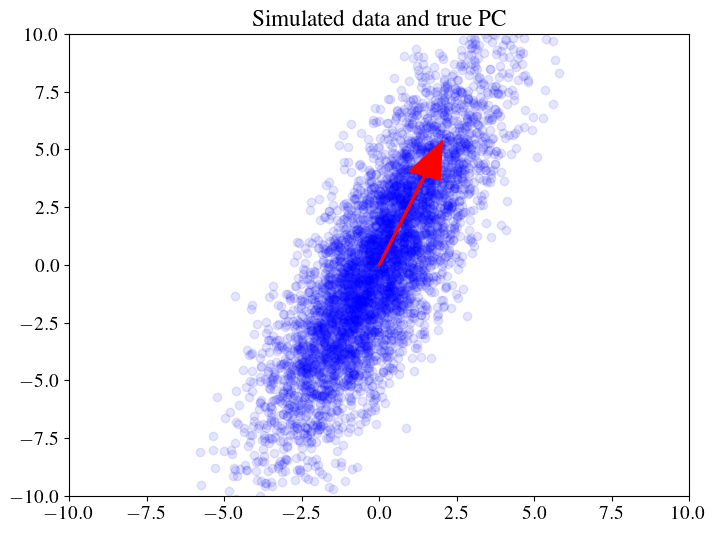

In [6]:
plt.scatter(train_data[x()][:,0], train_data[x()][:,1], color='blue', alpha=0.1)
plt.arrow(0, 0, *train_data[w()].flatten(), linewidth=2, color='red', head_width=1)
plt.axis([-10, 10, -10, 10])
plt.title("Simulated data and true PC")
plt.show()

To recover classical PCA, marginalize out the latent variable to find
$x_i \sim N(0, W W^\top + \sigma^2 I_D)$ and notice that when
observation noise $\sigma^2 \to 0$ the maximum likelihood estimate
for $W$ is the classical PCA objective of
best (in $L^2$-norm sense) rank $K$ approximation to the empirical covariance
$X X^\top$.

This can be solved through singular value decomposition (SVD), and in the following
cell we compute and visualize the classical PCA estimate for this example.

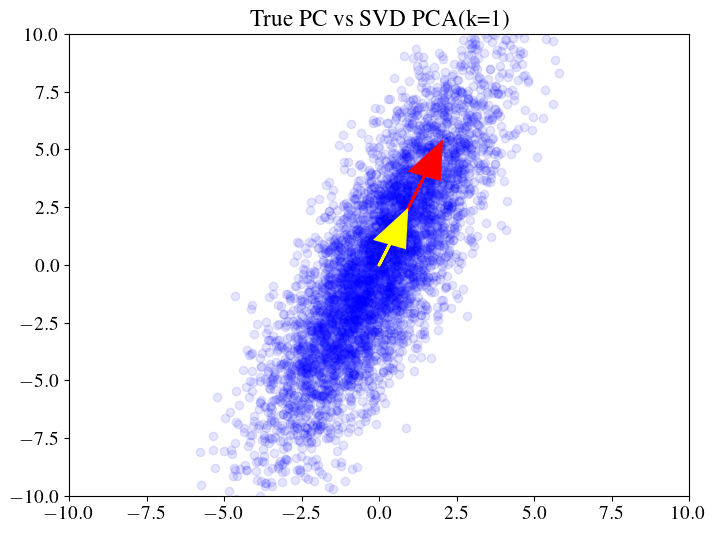

In [7]:
plt.scatter(train_data[x()][:,0], train_data[x()][:,1], color='blue', alpha=0.1)
plt.arrow(0, 0, *train_data[w()].flatten(), linewidth=2, color='red', head_width=1)
plt.arrow(0, 0, *train_data[x()].svd().V[:,0], linewidth=2, color='yellow', head_width=1)
plt.axis([-10, 10, -10, 10])
plt.title("True PC vs SVD PCA(k=1)")
plt.show()

# Variational Model

Classical PCA does not utilize the prior distribution $W_{ij} \sim N(0, 4)$.
In this synthetic setting where the prior is known to be the data generating
process, this is a missed opportunity!

To incorporate the prior in a Bayesian framework, we consider PPCA as a Bayesian
inference problem with target posterior $p(W,z \mid x) \propto p(x|W,z) p(W) p(z)$.

## Maximum A Posteriori (MAP) Inference

Here we use [maximum a posteriori (MAP) inference](https://beanmachine.org/api/beanmachine.ppl.inference.vi.html?highlight=map#beanmachine.ppl.inference.vi.MAP)
to find the values of latent variables $W$ and $z$ which maximize the posterior $p(W, z \mid x)$.
MAP inference can be a good choice if you need a Bayesian treatment which incorporates prior distributions
but do not need uncertainty estimates.

It generalizes across different choices of prior distributions, and it returns a point estimate which trades off between the prior $W \sim N(0, 4)$
and the likelihood $x \mid W \sim N(0, W W^\top + \sigma^2 I_D)$.

As a gradient descent algorithm, it is slower than classical PCA which can
utilize optimized linear algebra libraries for SVD).

  0%|          | 0/1000 [00:00<?, ?it/s]

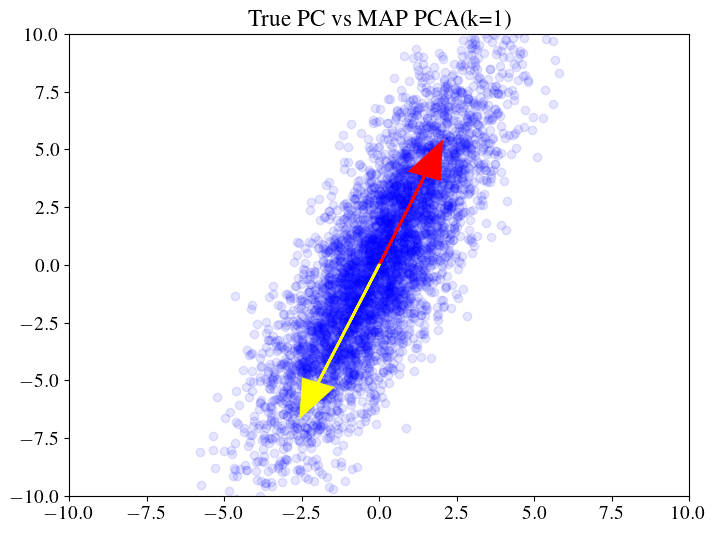

In [8]:
v_world = MAP(
    queries=[w(), z()],
    observations={x(): train_data[x()]},
).infer(
    num_steps=1000,
)
plt.scatter(train_data[x()][:,0], train_data[x()][:,1], color='blue', alpha=0.1)
plt.arrow(0, 0, *train_data[w()].flatten(), linewidth=2, color='red', head_width=1)
plt.arrow(0, 0, *v_world.get_guide_distribution(w()).mean.flatten().detach(), linewidth=2, color='yellow', head_width=1)
plt.axis([-10, 10, -10, 10])
plt.title("True PC vs MAP PCA(k=1)")
plt.show()

## Automatic Differentiation Variational Inference (ADVI)

If posterior uncertainty estimates are required and a mean-field Gaussian factorization
to the posterior approximation $q(z) = \prod_i N(z_i; \mu_i, \sigma_i)$ is acceptable,
then ADVI can be an appropriate choice.

As a pedagogical exercise, we first show how ADVI can be expressed using Bean Machine's [`VariationalInfer`](https://beanmachine.org/api/beanmachine.ppl.inference.vi.variational_infer.html)
API. It is a lower-level API which is useful when control over variational
parameter initialization and non-trivial factorizations of guide distributions
are required.

In [9]:
q_z_loc = bm.param(lambda: torch.zeros((N,K)))
q_z_scale = bm.param(lambda: torch.zeros((N,K)))
q_w_loc = bm.param(lambda: torch.zeros((K,D)))
q_w_scale = bm.param(lambda: torch.zeros((K,D)))

@bm.random_variable
def q_z():
    return dist.Normal(q_z_loc(), torch.nn.functional.softplus(q_z_scale()))

@bm.random_variable
def q_w():
    return dist.Normal(q_w_loc(), torch.nn.functional.softplus(q_w_scale()))

v_world = VariationalInfer(
    queries_to_guides={
        z(): q_z(),
        w(): q_w(),
    },
    observations={
        x(): train_data[x()],
    },
).infer(
    num_steps=1000,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

As ADVI yields a distributional estimate $N(\mu_W, \sigma_W)$ over principal components $W \in \mathbb{R}^{2}$, below we plot
100 samples from the ADVI variational approximation

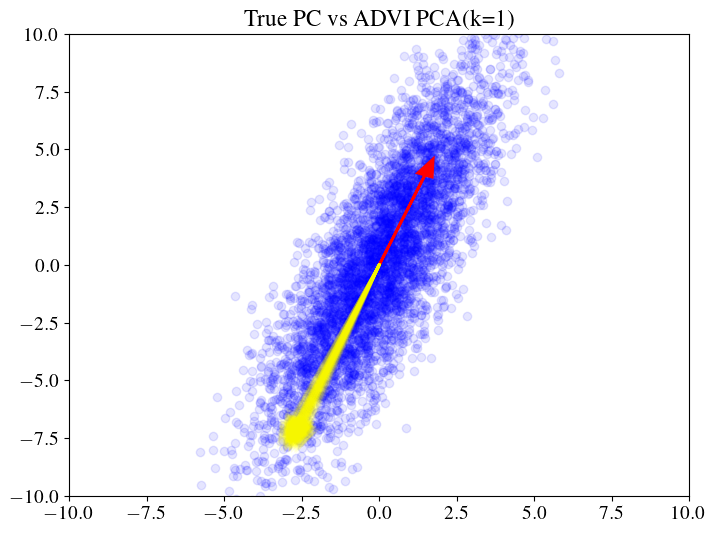

In [10]:
plt.scatter(train_data[x()][:,0], train_data[x()][:,1], color='blue', alpha=0.1)
plt.arrow(0, 0, *train_data[w()].flatten(), linewidth=2, color='red', head_width=0.5)
for _ in range(100):
    plt.arrow(0, 0, *2*v_world.get_guide_distribution(w()).sample().flatten().detach(), linewidth=2, color='yellow', head_width=0.5, alpha=0.1)
plt.axis([-10, 10, -10, 10])
plt.title("True PC vs ADVI PCA(k=1)")
plt.show()

In practice, we recommend the [`AutoGuide`](https://beanmachine.org/api/beanmachine.ppl.inference.vi.autoguide.html)
API for convenience when mean-field assumptions such as those used for ADVI are appropriate. The following cell shows
how to automatically define and use ADVI guides for variational inference.

In [11]:
v_world = ADVI(
    queries=[w(), z()],
    observations={x(): train_data[x()]},
).infer(
    num_steps=1000,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

# Visualization

We visualize the variational guide distribution obtained for the principal component $W \in \mathbb{R}^2$.
It should be aligned (up to scaling) with the true principal component.

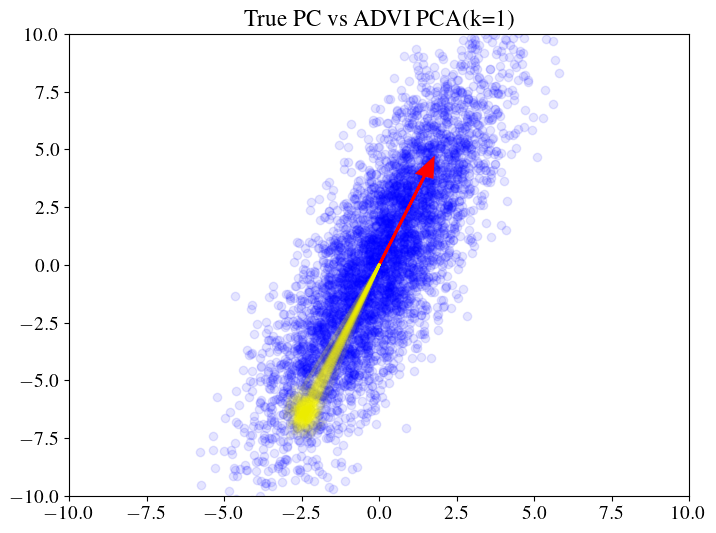

In [12]:
plt.scatter(train_data[x()][:,0], train_data[x()][:,1], color='blue', alpha=0.1)
plt.arrow(0, 0, *train_data[w()].flatten(), linewidth=2, color='red', head_width=0.5)
for _ in range(100):
    plt.arrow(0, 0, *2*v_world.get_guide_distribution(w()).sample().flatten().detach(), linewidth=2, color='yellow', head_width=0.5, alpha=0.05)
plt.axis([-10, 10, -10, 10])
plt.title("True PC vs ADVI PCA(k=1)")
plt.show()

Below we visualize the projection of every data point $x_i$
on to the lower-dimensional subspace spanned by the principal
component $W$.

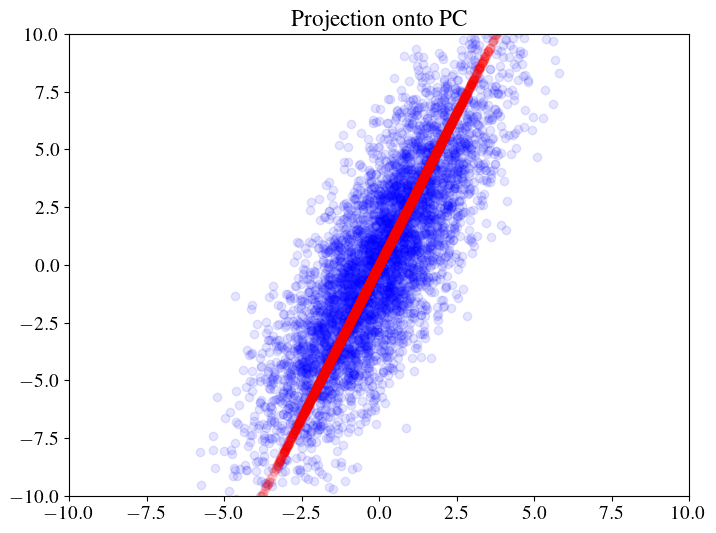

In [13]:
with torch.no_grad():
    plt.scatter(train_data[x()][:,0], train_data[x()][:,1], color='blue', alpha=0.1)
    proj = v_world.get_guide_distribution(z()).mean @ v_world.get_guide_distribution(w()).mean
    plt.scatter(proj[:,0], proj[:,1], color='red', alpha=0.1)
    plt.axis([-10, 10, -10, 10])
    plt.title("Projection onto PC")
    plt.show()

As a final check, we verify whether the variational approximations generate data that is similar to the original generative model sample.

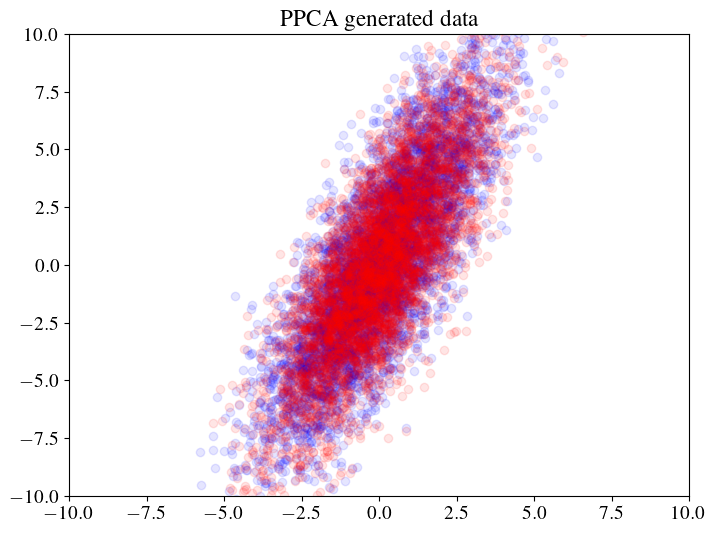

In [14]:
with torch.no_grad():
    plt.scatter(train_data[x()][:,0], train_data[x()][:,1], color='blue', alpha=0.1)
    x_gen = dist.Normal(
        loc=v_world.get_guide_distribution(z()).sample() @ v_world.get_guide_distribution(w()).sample(),
        scale=sigma,
    ).sample()
    plt.scatter(x_gen[:,0], x_gen[:,1], color='red', alpha=0.1)
    plt.axis([-10, 10, -10, 10])
    plt.title("PPCA generated data")
    plt.show()